In [1]:
import numpy as np
import numpy.linalg as la
import os
from ctypes import c_int, c_double, POINTER, cdll
from tqdm import tqdm

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': (8, 6)})

In [2]:
# Release dll if loaded
dll = None
# Compile cuda code and load dll
os.system("pwsh ./run.ps1 > log")
dll = cdll.LoadLibrary("./build/Release/kernel.dll")
## Define function signatures
# # void call_qpe_kernel(double* data, int nAll, int T, int R, bool unbiased)
# dll.call_qpe_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int, c_int]
# # void call_oqae_kernel(double* data, int nAll, int T)
# dll.call_oqae_kernel.argtypes = [POINTER(c_double), c_int, c_int]
# void call_mlae_kernel(double* data, int nAll, int length, int* Ms, int* Rs, int precision)
dll.call_mlae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), POINTER(c_int), c_int]
# void call_rqae_kernel(double* data, int nAll, int length, int* Ms, double eta, int precision)
dll.call_rqae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), c_double, c_int]

In [3]:
nSample = 4096
stats = {}

# Load data
stats["IQAE"] = np.loadtxt("iqae/iqae.txt", delimiter=",")
stats["ChebPE"] = np.loadtxt("chebpe/chebpe.txt", delimiter=",")

MLAE - Fixing R=32

In [4]:
stat_MLAE = []
R_MLAE = 32
for length in tqdm(range(3, 10)):
    src = np.random.random(nSample)
    res = np.copy(src)
    Rs = np.array([      R_MLAE for _ in range(length)], dtype=np.int32)
    Ms = np.array([(1 << i | 1) for i in range(length)], dtype=np.int32)
    cost = np.sum(Rs * Ms)
    dll.call_mlae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, length, Ms.ctypes.data_as(POINTER(c_int)), Rs.ctypes.data_as(POINTER(c_int)), 10000)
    err = la.norm(res - src) / np.sqrt(nSample)
    err5p = sorted(np.abs(res - src))[int(0.05 * nSample)]
    stat_MLAE.append([cost, err, err5p])
stats["MLAE"] = stat_MLAE
for stat in stat_MLAE:
    print(f'{stat[0]}\t{stat[1]*stat[0]:.6f}\t{stat[2]*stat[0]:.6f}')

100%|██████████| 7/7 [00:17<00:00,  2.43s/it]

288	4.480239	0.182976
576	4.776540	0.192442
1120	5.278153	0.225334
2176	5.216182	0.208544
4256	5.452473	0.221677
8384	5.167410	0.209614
16608	6.422059	0.247168


DJQAE - $R = 32, c = 2$

In [5]:
stat_DJQAE = []
R_DJQAE = 32
for length in tqdm(range(3, 10)):
    src = np.random.random(nSample)
    res = np.copy(src)
    Rs = [     R_DJQAE for _ in range(length-1)]
    Ms = [(1 << i | 1) for i in range(length-1)]
    lastM = (1 << (length - 1)) | 1
    jitterMin = max(Ms[-1], round(lastM - np.log2(lastM * 2)))
    jitterMax = round(lastM + np.log2(lastM * 2))
    jitterR = round(R_DJQAE / (jitterMax - jitterMin + 1))
    Rs = np.array(Rs + [jitterR] * (jitterMax - jitterMin + 1), dtype=np.int32)
    Ms = np.array(Ms + list(range(jitterMin, jitterMax + 1)), dtype=np.int32)
    cost = np.sum(Rs * Ms)
    dll.call_mlae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, length, Ms.ctypes.data_as(POINTER(c_int)), Rs.ctypes.data_as(POINTER(c_int)), 10000)
    err = la.norm(res - src) / np.sqrt(nSample)
    err5p = sorted(np.abs(res - src))[int(0.05 * nSample)]
    stat_DJQAE.append([cost, err, err5p])
    # print(f"Rs: {Rs}, Ms: {Ms}, Factor: {cost*err} & {cost*err5p}")
stats["DJQAE"] = stat_DJQAE
for stat in stat_DJQAE:
    print(f'{stat[0]}\t{stat[1]*stat[0]:.6f}\t{stat[2]*stat[0]:.6f}')

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]

293	12.460226	0.342407
612	8.950169	0.356224
1137	8.934717	0.415049
1978	8.096479	0.375092
4126	8.802787	0.350569
8642	9.162962	0.360562
18150	10.412409	0.490122


RQAE - Fixing $R_0=16$

In [6]:
stat_RQAE = []
R0_RQAE = 16
for D in tqdm(1<<np.arange(3, 12)):
    src = np.random.random(nSample)
    res = np.copy(src)
    cdf = np.cumsum(1 / np.arange(1, D+1))
    length = round(R0_RQAE * cdf[-1])
    cdf /= cdf[-1]  # normalize to 1
    Ms = np.array([np.searchsorted(cdf, np.random.random()) + 1 for _ in range(length)], dtype=np.int32)
    cost = np.sum(Ms)
    dll.call_rqae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, length, Ms.ctypes.data_as(POINTER(c_int)), 1.0, 10000)
    err = la.norm(res - src) / np.sqrt(nSample)
    err5p = sorted(np.abs(res - src))[int(0.05 * nSample)]
    stat_RQAE.append([cost, err, err5p])
stats["RQAE"] = stat_RQAE
for stat in stat_RQAE:
    print(f'{stat[0]}\t{stat[1]*stat[0]:.6f}\t{stat[2]*stat[0]:.6f}')

100%|██████████| 9/9 [14:28<00:00, 96.47s/it] 

143	2.744828	0.114858
255	2.847173	0.113898
433	2.615837	0.113617
1140	2.850446	0.130013
2076	3.091369	0.118406
4360	2.644651	0.153607
8494	2.885527	0.134726
14653	2.835830	0.128637
31877	3.050610	0.174201


Plot $N$ - $N\cdot\epsilon$

key: IQAE, length: 6
key: ChebPE, length: 7
key: MLAE, length: 7
key: DJQAE, length: 7
key: RQAE, length: 9


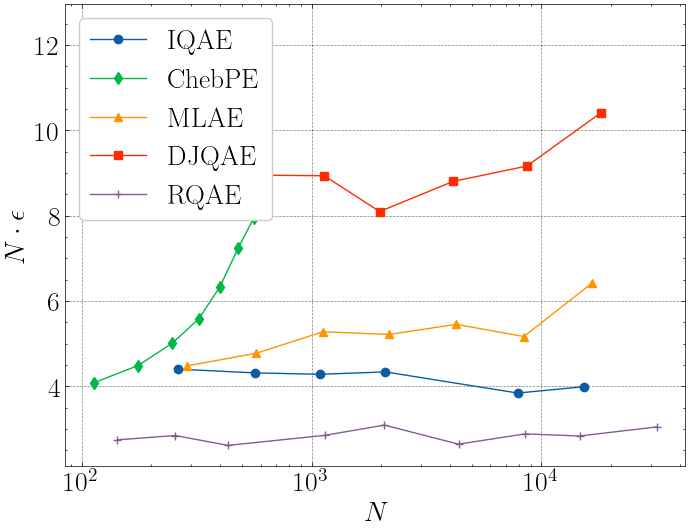

In [ ]:
for idx, key in enumerate(stats):
    cost, err, err5p = np.array(stats[key]).T
    plt.plot(cost, cost*err, label=key, marker="od^s+h"[idx])
plt.xscale("log")
plt.xlabel("$N$")
plt.ylabel("$N \\cdot \\epsilon$")
plt.grid(True)
plt.legend(loc="upper left")
plt.savefig("compare_noiseless.pdf")
plt.show()

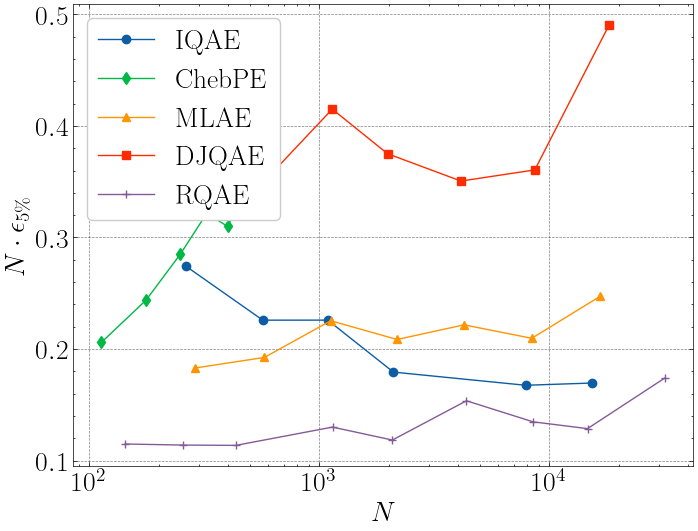

In [ ]:
for idx, key in enumerate(stats):
    cost, err, err5p = np.array(stats[key]).T
    plt.plot(cost, cost*err5p, label=key, marker="od^s+h"[idx])
plt.xscale("log")
plt.xlabel("$N$")
plt.ylabel("$N \\cdot \\epsilon_{5\\%}$")
plt.grid(True)
plt.legend(loc="upper left")
plt.savefig("compare_noiseless_5p.pdf")
plt.show()